## 导入必要的包

In [1]:
import tensorflow as tf


print('TensorFlow Version', tf.__version__)
print('GPU is ', 'available.' if tf.test.is_gpu_available() else 'NOT AVAILABLE!')

TensorFlow Version 2.0.0
GPU is  available.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import glob

from IPython import display

## 数据读取

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

train_labels = tf.one_hot(train_labels, depth=10)
train_labels = tf.cast(train_labels, tf.float32)

In [5]:
buffer_size = 60000
batch_size = 256

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size).batch(batch_size).prefetch(1)

## 生成器模型定义

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(110,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [8]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1379840   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

以标签 0 为例

In [9]:
noise = tf.random.normal([1, 100])
labels = [0]
labels = tf.one_hot(labels, depth=10)
labels = tf.cast(labels, tf.float32)
noise = tf.concat([noise, labels], 1)

print('noise.shape:', noise.shape)

noise.shape: (1, 110)


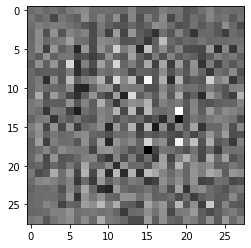

In [10]:
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [11]:
generated_image.shape

TensorShape([1, 28, 28, 1])

In [12]:
labels_input = tf.reshape(labels, [1, 1, 1, 10])

In [13]:
generated_input = tf.concat([generated_image, labels_input * tf.ones([1, 28, 28, 10])], 3)

In [14]:
generated_input.shape

TensorShape([1, 28, 28, 11])

## 判别器模型定义

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), 
                                     padding='same', input_shape=[28, 28, 11]))
    
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [16]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        17664     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [17]:
decision = discriminator(generated_input)
print(decision)

tf.Tensor([[-0.06202808]], shape=(1, 1), dtype=float32)


## 训练设置

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 判别器损失函数

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

### 生成器损失函数

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 两者优化器

In [16]:
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
checkpoint_dir = './Ctraining_checkpoints'

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

### 定义超参数

In [18]:
epochs = 20
noise_dim = 100
num_examples_to_generate = 100

### 产生随机种子

In [19]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
labels = [i % 10 for i in range(num_examples_to_generate)]
labels = tf.one_hot(labels, depth=10)
labels = tf.cast(labels, tf.float32)
seed = tf.concat([seed, labels], 1)
print(seed.shape)

(100, 110)


## 定义单次训练过程  
@tf.function 注解使函数被“编译”为计算图/静态图模式

In [20]:
@tf.function
def train_step(data_batch):
    
    images = data_batch[0]
    labels = data_batch[1]
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        noise = tf.random.normal([images.get_shape()[0], noise_dim])
        noise_input = tf.concat([noise, labels], 1)
        generated_images = generator(noise_input, training=True)
        
        labels_input = tf.reshape(labels, [images.get_shape()[0], 1, 1, 10])
        
        images_input = tf.concat([images, labels_input * tf.ones([images.get_shape()[0], 28, 28, 10])], 3)
        
        generated_input = tf.concat([generated_images, labels_input * tf.ones([images.get_shape()[0], 28, 28, 10])], 3)
        
        real_output = discriminator(images_input, training=True)
        fake_output = discriminator(generated_input, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

## 生成和保存图片

In [21]:
def generate_and_save_images(model, epoch, test_input):
    
    if not os.path.exists('./Cgenerate_images'):
        os.mkdir('./Cgenerate_images')
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(10, 10))
    
    for i in range(predictions.shape[0]):
        plt.subplot(10, 10, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.savefig('./Cgenerate_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## 训练函数定义

In [22]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for data_batch in dataset:
            train_step(data_batch)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

利用 `%%time` 获取 cell 每运行一次所花费的时间

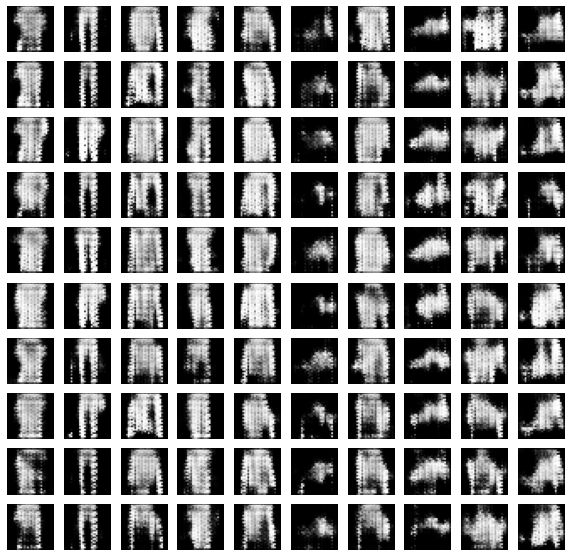

Time for epoch 20 is 48.72547435760498 sec
Wall time: 16min 4s


In [24]:
%%time
train(train_dataset, epochs)

## 可视化

### 显示单张图

In [25]:
def display_image(epoch_no):
    return PIL.Image.open('./Cgenerate_images/image_at_epoch_{:04d}.png'.format(epoch_no))

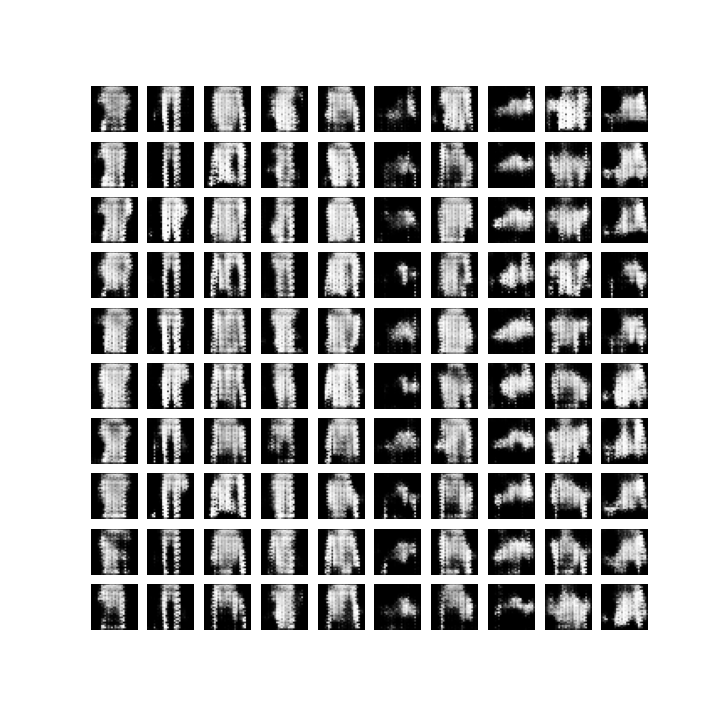

In [26]:
display_image(epochs)

### 定义动图函数

In [27]:
import imageio

anim_file = 'Cdcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./Cgenerate_images/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

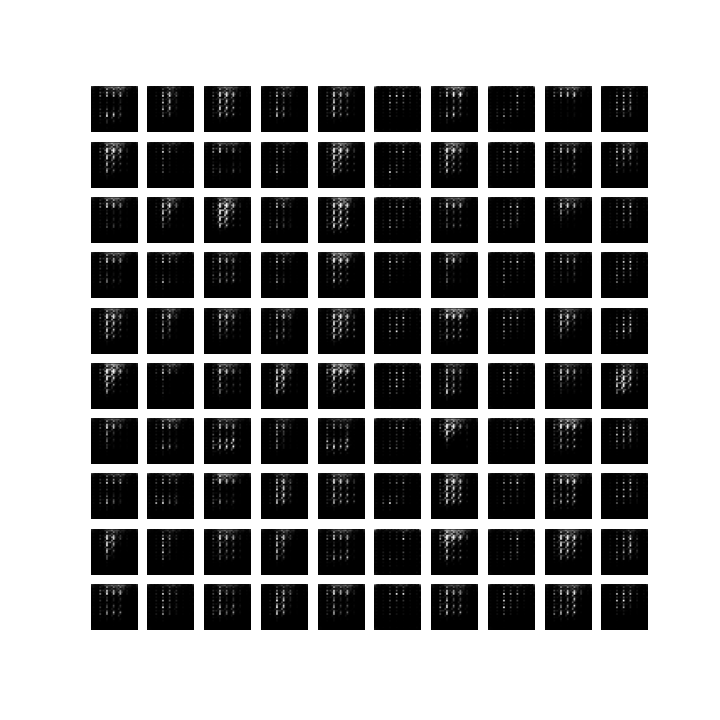

In [28]:
display.Image(filename=anim_file)